# Capstone - Step5: 



## Extract a sub-image with a bounding box, then export it to GeoTIFF format while keeping the original metadata
<hr style="border:2px solid #007700;">

In [1]:
import pystac_client
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import rasterio
from rasterio.crs import CRS
from rasterio.warp import transform
from rasterio.windows import from_bounds
from rasterio.mask import mask
import numpy as np
from geopy.distance import geodesic
from matplotlib import pyplot as plt
from rasterio.windows import Window, transform as window_transform

In [2]:
# using Brazil Data Cube as data source
service = pystac_client.Client.open('https://data.inpe.br/bdc/stac/v1/')

In [5]:
# using Collection Sentinel-2
collection = service.get_collection('S2-16D-2')


### Region of Interest (ROI)


We define a boundary box for the data access and extraction

In [9]:
# Define de ROI bbox
center_point = (-15.885858,-47.725772) # Taboquinha

# Define the distance to extend
distance_km = 1.35

# Calculate the boundary box
bb_north = geodesic(kilometers=distance_km).destination(center_point, 0).latitude
bb_south = geodesic(kilometers=distance_km).destination(center_point, 180).latitude
bb_east = geodesic(kilometers=distance_km).destination(center_point, 90).longitude
bb_west = geodesic(kilometers=distance_km).destination(center_point, 270).longitude
bbox = (bb_west, bb_south, bb_east, bb_north)

print(f"Bounding box:\nSouth: {bb_south} \tWest: {bb_west}\nNorth: {bb_north} \tEast: {bb_east}")
print(f"bbox = {bbox}")

Bounding box:
South: -15.898057796775847 	West: -47.73837763779424
North: -15.873658189482754 	East: -47.71316636220576
bbox = (-47.73837763779424, -15.898057796775847, -47.71316636220576, -15.873658189482754)


In [11]:
# To minimize the clouds distorition, let's define a search time interval from july to august (in general, less cloudy season).
datetime = '2024-07-01/2024-08-31'

In [13]:
# search items
item_search = service.search(bbox=bbox,
                             datetime=datetime,
                             collections=['S2-16D-2'])
item_search

In [15]:
print(f'number of images in the collection: {item_search.matched()}')

number of images in the collection: 5


# Using RasterIO and NumPy to externalize and visualize the images
<hr style="border:1px solid #007700;">

We have implemented a `read` method that allows to retrieve part of an image according to a rectangle specified in `EPSG:4326` (latitude and longitude).

In [19]:
def read_multiple_items(items, band_name, bbox, masked=True, crs=None):
    source_crs = CRS.from_string('EPSG:4326')
    if crs:
        source_crs = CRS.from_string(crs)
    
    data_list = []
    transforms = []
    crs_list = []
    
    for item in items:
        uri = item.assets[band_name].href
        
        # Expects the bounding box has 4 values
        w, s, e, n = bbox
        
        with rasterio.open(uri) as dataset:
            # Transform the bounding box to the dataset's CRS
            xs, ys = transform(source_crs, dataset.crs, [w, e], [s, n])
            # Create a window from the transformed bounds
            window = from_bounds(xs[0], ys[0], xs[1], ys[1], dataset.transform)
            # Read the data within the window
            data = dataset.read(1, window=window, masked=masked)
            # Get the transform for the windowed data
            window_transform = dataset.window_transform(window)
            # Get the CRS of the dataset
            data_crs = dataset.crs
            
            data_list.append(data)
            transforms.append(window_transform)
            crs_list.append(data_crs)
    
    return data_list, transforms, crs_list

In [21]:
# Convert item_search.items() to a list to reuse
items_list = list(item_search.items())

In [22]:
# Consider four bands: red, green, blue and NIR.
# Observe that the read function consider a collection of images
red_data_list, red_transforms, red_crs_list = read_multiple_items(items_list, 'B04', bbox)
green_data_list, green_transforms, green_crs_list = read_multiple_items(items_list, 'B03', bbox)
blue_data_list, blue_transforms, blue_crs_list = read_multiple_items(items_list, 'B02', bbox)
nir_data_list, nir_transforms, nir_crs_list = read_multiple_items(items_list, 'B08', bbox)


In [24]:
# Compute median bands to mitigate the cloud distortion
def compute_median_band(band_data_list):
    data_stack = ma.stack(band_data_list, axis=0)
    median_band = ma.median(data_stack, axis=0)
    return median_band

In [25]:
median_red = compute_median_band(red_data_list)
median_green = compute_median_band(green_data_list)
median_blue = compute_median_band(blue_data_list)
median_nir = compute_median_band(nir_data_list)

In [26]:
# Prepare median bands for writing
# force float32 data type for later treatment with TensorFlow
nodata_value = -9999.0
median_red_filled = median_red.filled(nodata_value).astype('float32')
median_green_filled = median_green.filled(nodata_value).astype('float32')
median_blue_filled = median_blue.filled(nodata_value).astype('float32')
median_nir_filled = median_nir.filled(nodata_value).astype('float32')


Setting the image size as 256x256 pixels

In [28]:
# Extract the first 256 rows and columns for each band
median_red_subset = median_red_filled[0:256, 0:256]
median_green_subset = median_green_filled[0:256, 0:256]
median_blue_subset = median_blue_filled[0:256, 0:256]
median_nir_subset = median_nir_filled[0:256, 0:256]

In [29]:
# Create a Window object for the subset
window = Window(0, 0, 256, 256)

In [30]:
# Compute the new affine transform for the subset
reference_transform = red_transforms[0]
new_transform = window_transform(window, reference_transform)

In [38]:
# Stack the median subsets
stacked_median_array = np.stack([
    median_red_subset,
    median_green_subset,
    median_blue_subset,
    median_nir_subset
])

In [40]:
# Update the output height and width
output_height, output_width = median_red_subset.shape

In [42]:
output_filename = 'median_composite.tif'
reference_crs = red_crs_list[0]



In [51]:
# Write the output file
with rasterio.open(
    output_filename,
    'w',
    driver='GTiff',
    height=output_height,
    width=output_width,
    count=4,
    dtype='float32',
    crs=reference_crs,
    transform=new_transform,
    nodata=nodata_value
) as dst:
    dst.write(stacked_median_array)
    dst.set_band_description(1, 'Red')
    dst.set_band_description(2, 'Green')
    dst.set_band_description(3, 'Blue')
    dst.set_band_description(4, 'NIR')

Visualize the Extracted 

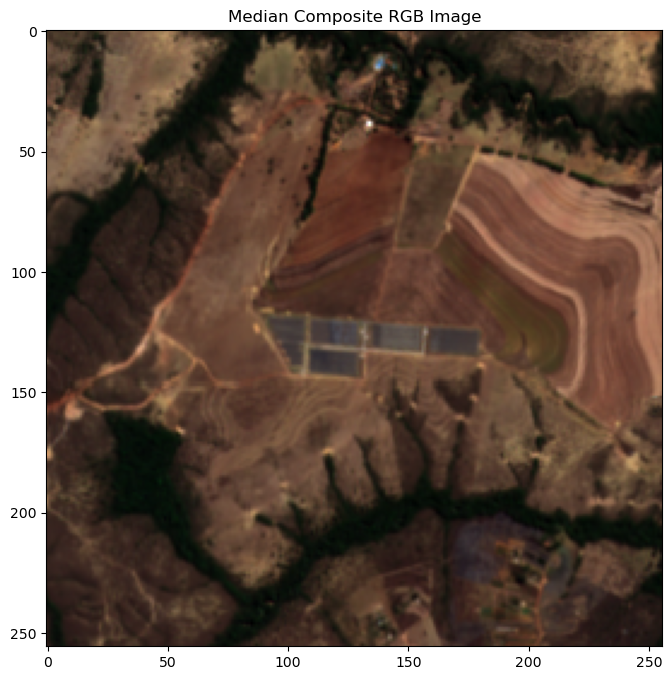

In [53]:
# normalize the array for visualization
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Stack normalized RGB bands
rgb_median = np.dstack((
    normalize(median_red_subset),
    normalize(median_green_subset),
    normalize(median_blue_subset)
))

# Plot the RGB image
plt.figure(figsize=(8, 8))
plt.imshow(rgb_median)
plt.title('Median Composite RGB Image')
plt.show()